# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** June 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter, geopandas

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github]()

---
**Assignment:**

Using a shapefile with country boundaries, show a table (use a pandas dataframe) of the percent area of each country in South America where there is statistically significant anomalous temperature during strong winter El Nino events. Also calculate the mean temperature anomaly across all grid cells in each country and across only grid cells in each country that have statisically significant anomalies. 

&emsp;Hints:
- Use World_Countries_Generalized.shp for country boundaries and subset to South America. Here's the code to download the shapefile
```
from urllib.request import urlretrieve

# create a folder for data downloads
if not os.path.exists('../data/World_Countries'):
    os.makedirs('../data/World_Countries')

# filenames to save data to and download urls
base_filename='../data/World_Countries/World_Countries'

shpfile_info=  {'.cpg':'https://osf.io/5xrgc/download',
                '.dbf':'https://osf.io/3a6rp/download',
                '.prj':'https://osf.io/43mnp/download',
                '.shp':'https://osf.io/r4dez/download',
                '.shp.xml':'https://osf.io/s4cvy/download',
                '.shx':'https://osf.io/kp6cm/download'}    
for ext,url in shpfile_info.items():
    filename=base_filename+ext
    print('downloading',filename)
    urlretrieve(url,filename) # download and save data
```
- Repeat the appropriate steps from science questions 1 and 3
- Use the country boundaries and your gridded results to quantify how much area of each country experiences statistically significant anomalous T and PR (use p<=0.1)
- Format your results in a pandas dataframe. Your final dataframe should have columns for COUNTRY and T_PERCENT_AREA.

# Import packages and define workspace

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import geopandas as gpd
import warnings
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

import shapely
import xagg
# from cdo import *
# cdo   = Cdo()  

In [2]:
# create a folder for data downloads
if not os.path.exists('../data/World_Countries'):
    os.makedirs('../data/World_Countries')

In [3]:
# filenames to save data to and download urls
base_filename='../data/World_Countries/World_Countries'

shpfile_info=  {'.cpg':'https://osf.io/5xrgc/download',
                '.dbf':'https://osf.io/3a6rp/download',
                '.prj':'https://osf.io/43mnp/download',
                '.shp':'https://osf.io/r4dez/download',
                '.shp.xml':'https://osf.io/s4cvy/download',
                '.shx':'https://osf.io/kp6cm/download'}

# files we've already downloaded
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'

# Obtaining the data

We'll use a shapefile of country boundaries called [World Countries, originally obtained from ESRI ArcGIS Hub](https://hub.arcgis.com/datasets/esri::world-countries/explore) in June 2024 and copied to the [enso component of the MSU_py_training OSF project](https://osf.io/e726y/). 

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data files will then be located on your computer. Files total approximately 130MB in size.**
</b></font> 

In [ ]:
# download shapefile

for ext,url in shpfile_info.items():
    filename=base_filename+ext
    print('downloading',filename)
    urlretrieve(url,filename) # download and save data

# Data Cleaning

We'll copy over the data cleaning steps from the enso_analysis.ipynb as well as subset global country boundaries to South American countries 

In [4]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

In [5]:
# data cleaning copied from enso_analysis.ipynb

# Nino 3.4 data
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten() 
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates}) 
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  # subset in time
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  # long term means for each month
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# check first and last time is the same for all data
variables=[nino, t_anom] # list of arrays
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

# clean up
del ds, nino_raw, t, t_anom_5180, t_base

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


In [6]:
# load shapefile of global country boundaries
countries=gpd.read_file(base_filename+'.shp')
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Afghanistan,AFG,Asia,Primary land,5,Afghanistan,"POLYGON ((7903664.312 4647353.724, 7904616.405..."
1,Albania,ALB,Europe,Primary land,5,Albania,"POLYGON ((2198549.632 5255559.625, 2198549.632..."
2,Albania,ALB,Europe,Very small island,1,Albania,"MULTIPOLYGON (((2225504.394 4833346.591, 22255..."
3,Albania,ALB,Europe,Small island,2,Albania,"MULTIPOLYGON (((2146282.762 4939350.329, 21465..."
4,Algeria,DZA,Africa,Small island,2,Algeria,"POLYGON ((-125686.175 4262793.127, -125721.541..."
...,...,...,...,...,...,...,...
646,Yemen,YEM,Asia,Very small island,1,Yemen,"MULTIPOLYGON (((5803828.604 1395645.899, 58035..."
647,Yemen,YEM,Asia,Small island,2,Yemen,"MULTIPOLYGON (((5931926.381 1360057.795, 59327..."
648,Yemen,YEM,Asia,Medium island,3,Yemen,"POLYGON ((5960626.667 1426907.772, 5961018.46 ..."
649,Zambia,ZMB,Africa,Primary land,5,Zambia,"POLYGON ((3461259.84 -964526.128, 3462999.22 -..."


In [7]:
countries.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# trying unproject first

# subset to south america
countries=countries.loc[(countries['CONTINENT']=='South America')
                        &(countries['LAND_TYPE'].str.contains('Primary land'))].reset_index(drop=True)
# countries=countries.to_crs("epsg:4326")
countries

# array(['Argentina', 'Aruba', 'Bolivia', 'Bonaire', 'Brazil', 'Chile',
#        'Colombia', 'Curacao', 'Ecuador', 'Falkland Islands',
#        'French Guiana', 'Guyana', 'Paraguay', 'Peru', 'Suriname',
#        'Trinidad and Tobago', 'Uruguay', 'Venezuela'], dtype=object)

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424..."
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716..."
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333..."
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619..."
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2..."
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.2443 -3.33325, -80.2438 -3..."
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.8391,..."
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8..."
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2..."
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166..."


In [9]:
from shapely.geometry.polygon import orient
def gpd_geographic_area(geodf):
    if not geodf.crs and geodf.crs.is_geographic:
        raise TypeError('geodataframe should have geographic coordinate system')
        
    geod = geodf.crs.get_geod()
    def area_calc(geom):
        if geom.geom_type not in ['MultiPolygon','Polygon']:
            return np.nan
        
        # For MultiPolygon do each separately
        if geom.geom_type=='MultiPolygon':
            return np.sum([area_calc(p) for p in geom.geoms])/(1000^2)

        # orient to ensure a counter-clockwise traversal. 
        # See https://pyproj4.github.io/pyproj/stable/api/geod.html
        # geometry_area_perimeter returns (area, perimeter)
        return geod.geometry_area_perimeter(orient(geom, 1))[0]/(1000^2)
    
    return geodf.geometry.apply(area_calc)

In [10]:
countries['area_km2']=gpd_geographic_area(countries)
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry,area_km2
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424...",2.764644e+06
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716...",1.080448e+09
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333...",8.409169e+06
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619...",6.863458e+05
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2...",1.130327e+06
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.2443 -3.33325, -80.2438 -3...",2.451759e+05
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.8391,...",8.302624e+07
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8...",2.095301e+05
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2...",3.999487e+08
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166...",1.289477e+09


In [ ]:
# # this function operates on a single polygon or multipolygon
# # and can be applied to a geodataframe
# def area_calc(geom):
#     if not all(geom.geom_type.isin(['MultiPolygon','Polygon'])):
#         raise TypeError('some geometries are not polygon or multipolygon')

#     geod = geom.crs.get_geod()        
#     if geom.geom_type=='MultiPolygon':
#         # For multipolygon do each polygon separately and sum
#         return np.sum([geod.geometry_area_perimeter(shapely.geometry.polygon.orient(p,1))[0]/(1000^2) for p in geom.geoms])
#     else:
#         return geod.geometry_area_perimeter(shapely.geometry.polygon.orient(geom,1))[0]/(1000^2)

In [ ]:
# # geod = countries.crs.get_geod()
# countries.geometry.apply(area_calc)
# # countries.apply(area_calc)

In [ ]:
# # get country areas
# geod = countries.crs.get_geod()




# from shapely.geometry.polygon import orient
# def gpd_geographic_area(geodf):
#     if not geodf.crs and geodf.crs.is_geographic:
#         raise TypeError('geodataframe should have geographic coordinate system')
        
#     geod = geodf.crs.get_geod()
#     def area_calc(geom):
#         if geom.geom_type not in ['MultiPolygon','Polygon']:
#             return np.nan
        
#         # For MultiPolygon do each separately
#         if geom.geom_type=='MultiPolygon':
#             return np.sum([area_calc(p) for p in geom.geoms])

#         # orient to ensure a counter-clockwise traversal. 
#         # See https://pyproj4.github.io/pyproj/stable/api/geod.html
#         # geometry_area_perimeter returns (area, perimeter)
#         return geod.geometry_area_perimeter(orient(geom, 1))[0]
    
#     return geodf.geometry.apply(area_calc)

# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the code that creates the array `nino_events` 

In [11]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our El Nino temperature anomaly composite and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb

t nino and non-nino sample sizes: 44 184


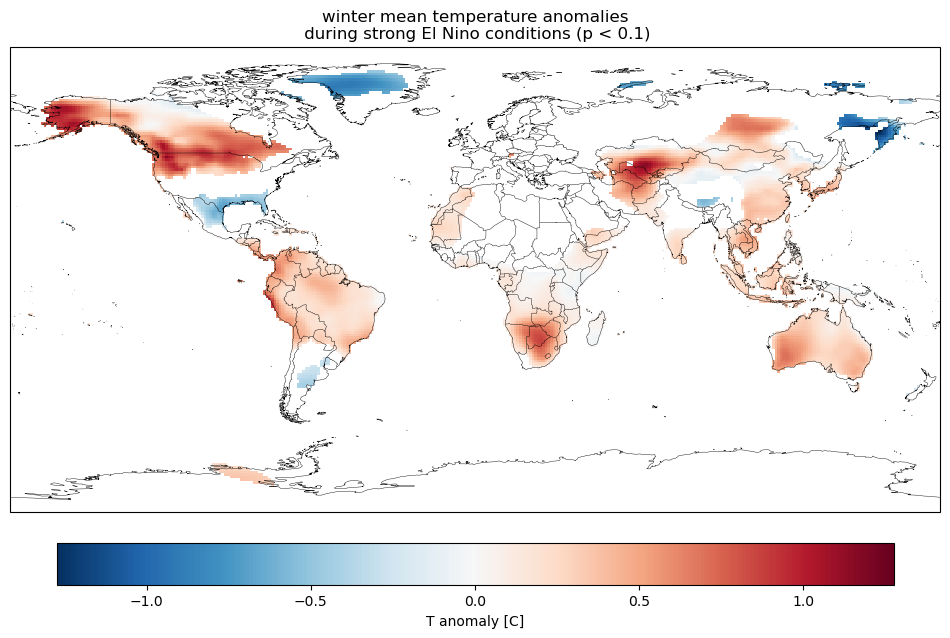

In [12]:
# copied from question 3 in enso_analysis.ipynb

# starting with el nino conditions, temperature
# get temperature anomalies only for times during strong el nino conditions
t_nino=t_anom.where(nino_events==1,drop=True)

# now separate out winter DJF months
# this is sample 1: winter months during strong el nino conditions
t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF'] 

# make a composite
t_nino_DJF_composite=t_nino_DJF.mean('time',keep_attrs=True)

# create a t sample that include all winter months DJF when there are not strong el nino conditions

# all months that don't fall in strong nino events
t_other=t_anom.where(nino_events!=1,drop=True) 

# pull out just DJF months
# this is sample 2: all winter months that are NOT during strong el nino conditions
t_other_DJF=t_other.groupby(t_other.time.dt.season)['DJF'] 

print('t nino and non-nino sample sizes:',t_nino_DJF.shape[0],t_other_DJF.shape[0]) 

# t-test for difference in means 
t_sigtest = ss.ttest_ind(t_nino_DJF, t_other_DJF, axis=0, equal_var=False)
# numpy --> xarray
t_nino_pval = xr.DataArray(t_sigtest.pvalue, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})


# plot el nino temperature anomalies where statistically significant at 90% level
pval=0.1

fig=plt.figure(figsize=(12,8))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_pval<pval).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'winter mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

plt.show()


Now we can use our shapefile to answer the question: what percent area of each country in South America experiences statistically significant anomalous temperature during strong winter El Nino events?

In [13]:
# now use the xagg package to compute the overlaps between grid cell polygons and country polygons
# pixel_overlaps computes the relative area of overlap for each grid cell polygon
# it takes an xarray dataset and a geopandas dataframe as inputs
# see https://xagg.readthedocs.io/en/latest/xagg.html#xagg.wrappers.pixel_overlaps
# and https://xagg.readthedocs.io/en/latest/xagg.html#xagg.core.get_pixel_overlaps
weightmap = xagg.pixel_overlaps(t_nino_DJF_composite,countries,subset_bbox=False)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [ ]:
# xa.pixel_overlaps function returns an object that contains 
# 1) a pandas dataframe with the grid cell polygon overlap information (.agg), 
# 2) a dictionary containing the xarray data array source grid info (.source_grid), 
# 3) a pandas series of geometry objects containing the geopandas source geometry info (.geometry)

# access the dataframe with .agg
weightmap.agg.head()

xagg.pixel_overlaps calculates how much relative area of a country polygon that each grid cell that intersects the country occupies. The column rel_area contains this information

In [ ]:
# the relative area of each pixel intersecting the first polygon/mulipolygon (Argentina)
# would be indexed like this, which returns a pandas series of 351 values
# in this case 351 grid cells of our xarray data array intersect the Argentina polygon
weightmap.agg['rel_area'][0][0]

In [ ]:
# the coordinates that correspond to the rel_area values (grid cell polygon centroids)
# would be indexed like this, which returns a list of 351 (lat,lon) tuples

print(weightmap.agg['coords'][0][0:4])

len(weightmap.agg['coords'][0])

For each country we want to create a dataframe where each row contains data for a single grid cell: relative area, lat, lon values, data value, pvalue. We'll test this merge of data on one country first, Boliva- index row 1 in the dataframe

In [14]:
# first create a pandas dataframe from our results t_nino_DJF_composite and t_nino_pval

# convert xarray data array objects to pandas dataframes including columns for lat and lon
t_nino_DJF_composite_df=t_nino_DJF_composite.to_dataframe().reset_index(level=[0,1])

t_nino_pval.name='pval' # data array needs a name to be successfully converted to dataframe
t_nino_pval_df=t_nino_pval.to_dataframe().reset_index(level=[0,1])

# merge pvalues into t_nino_DJF_composite_df
t_nino_DJF_composite_df=t_nino_DJF_composite_df.merge(t_nino_pval_df, how='left',on=['lat','lon'])
t_nino_DJF_composite_df

,lat,lon,tavg,pval
0,-89.5,-179.5,-0.054176,NaN
1,-89.5,-178.5,-0.053847,NaN
2,-89.5,-177.5,-0.053528,NaN
3,-89.5,-176.5,-0.053207,NaN
4,-89.5,-175.5,-0.052902,NaN
...,...,...,...,...
64795,89.5,175.5,NaN,NaN
64796,89.5,176.5,NaN,NaN
64797,89.5,177.5,NaN,NaN
64798,89.5,178.5,NaN,NaN


In [15]:
# now combine with the information from the weightmap for Bolivia (index row 1)
indexrow=1 # bolivia

# coordinates lat,lon to dataframe
df=pd.DataFrame(weightmap.agg['coords'][indexrow],columns=['lat','lon'])

# add rel_area as a dataframe column
df['rel_area']=weightmap.agg['rel_area'][indexrow][0].reset_index(drop=True)

# join the tavg and pval info
df=df.merge(t_nino_DJF_composite_df, how='left',on=['lat','lon'])
df

,lat,lon,rel_area,tavg,pval
0,-22.5,-68.5,0.000010,0.461847,1.215355e-08
1,-22.5,-67.5,0.007989,0.442622,1.475527e-08
2,-22.5,-66.5,0.002076,0.405034,3.258637e-07
3,-22.5,-65.5,0.000745,0.358098,2.185557e-05
4,-22.5,-64.5,0.003761,0.297633,1.095574e-03
...,...,...,...,...,...
119,-10.5,-67.5,0.005824,0.203045,3.171960e-08
120,-10.5,-66.5,0.010898,0.202780,5.261899e-09
121,-10.5,-65.5,0.007390,0.194686,2.435102e-09
122,-9.5,-66.5,0.001169,0.200270,7.235417e-09


We can see that the merge subsets the 64800 rows in t_nino_DJF_composite_df to just the 124 that overlap with the Bolivia polygon. This is because we chose to merge 'left' (merge into df). Merge 'right' (merge into t_nino_DJF_composite_df) would have kept all 64800 rows (global grid cells) and inserted nans for rel_area outside of Bolivia.

If we want to see which grid cells are ovelapping the Boliva polygon and how much each cell contributes to the polygon area, xagg has a function for that.

https://xagg.readthedocs.io/en/latest/xagg.html#xagg.classes.weightmap
https://xagg.readthedocs.io/en/latest/xagg.html#xagg.diag.diag_fig

lat/lon bounds not found in dataset; they will be created.


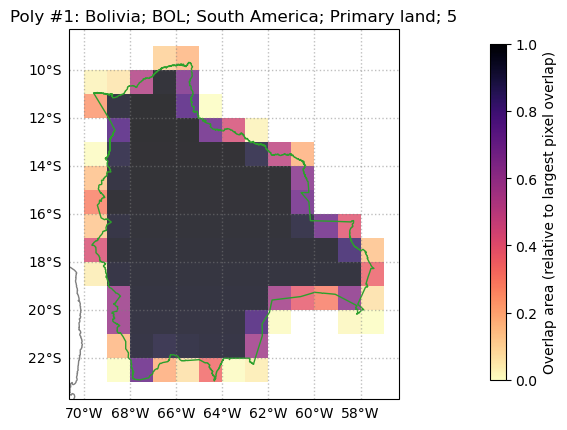

In [16]:
# show the relative grid cell weights in a figure
weightmap.diag_fig(indexrow,t_nino_DJF_composite.to_dataset())

In [ ]:
# # data_subset=t_nino_DJF_composite.sel(lat=slice(-20,0),lon=slice(-82,-68))
# data_subset=t_nino_DJF_composite.sel(lat=slice(9.5,11.5),lon=slice(-62,-60))
# # data_subset
# fig=plt.figure(figsize=(6,6))

# ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
# ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
# ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.3)

# # Make a copy
# cmap = plt.colormaps.get_cmap("RdBu_r").copy()

# # Choose the color
# cmap.set_bad('grey')

# data_subset.plot(cmap=cmap)#,cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})

# # # Gridlines
# # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['x','y','bottom','left'],
# #                     linewidth=1, color='dimgray', alpha=0.5, linestyle=':')

To get the relative area of Bolivia where nino winter temperature anomalies meet the 90% confidence level, we need to sum rel_area where pval <= 0.1

In [17]:
area_impacted=df.loc[df['pval']<=0.1].rel_area.sum()
area_impacted=round(area_impacted*100.)

print(area_impacted,'% of Bolivia experiences statistically significant temperature anomalies during strong winter el nino events')

100 % of Bolivia experiences statistically significant temperature anomalies during strong winter el nino events


To get the result for all countries we can write a function and call it in a loop. 

In [18]:
def percent_area_impacted(coords,rel_area,xr_pval):
    df=pd.DataFrame(coords,columns=['lat','lon'])
    df['rel_area']=rel_area.reset_index(drop=True)
    
    xr_pval.name='pval'
    pval_df=xr_pval.to_dataframe().reset_index(level=[0,1])
    df=df.merge(pval_df, how='left',on=['lat','lon'])

    area_impacted=round(df.loc[df['pval']<=0.1].rel_area.sum()*100.)
    return area_impacted

In [20]:
# loop through countries

results={}

for index,row in weightmap.agg.iterrows():
    answer=percent_area_impacted(row.coords,row.rel_area[0],t_nino_pval)
    results[row.COUNTRY]=answer

results_df=pd.DataFrame.from_dict(results,orient='index',columns=['T_PERCENT_AREA']).reset_index(names='COUNTRY')
results_df

,COUNTRY,T_PERCENT_AREA
0,Argentina,30
1,Bolivia,100
2,Brazil,98
3,Chile,33
4,Colombia,100
5,Ecuador,100
6,French Guiana,100
7,Guyana,100
8,Paraguay,83
9,Peru,100


add aggregate example to get the mean tavg for the country and the mean tavg for the statistically significant cells

In [29]:
test=xagg.core.aggregate(t_nino_DJF_composite,weightmap)
test=test.to_dataframe()

aggregating tavg...
all variables aggregated to polygons!


In [57]:
test=test[['COUNTRY','tavg']]
test=test.rename(columns={'tavg':'MEAN_T_ANOMALY'})
results_df=results_df.merge(test,how='left',on='COUNTRY')
results_df

KeyError: "['tavg'] not in index"

aggregating only the grid cells with statistically significant anomalies is a little more difficult

One approach would be to modify the weightmap and replace the pixel weights (rel_area) with zero for pixels that do not contain statistically significant anomalies

Let's try it out with Argentina


In [53]:
def modify_weights(weightmap_in,xr_pval,siglvl):

    # putting the country loop inside the function this time
    for index,row in weightmap_in.agg.iterrows():
        # get coords and rel_area into a df with one grid cell per row
        df=pd.DataFrame(row.coords,columns=['lat','lon'])
        df['rel_area']=row.rel_area[0].reset_index(drop=True)
        
        # merge in p values
        xr_pval.name='pval'
        pval_df=xr_pval.to_dataframe().reset_index(level=[0,1])
        df=df.merge(pval_df, how='left',on=['lat','lon'])

        # change rel_area to 0 for all cells with pvals that are not significant
        df.loc[df.pval>siglvl,'rel_area'] = 0

        # ammend the weightmap dataframe with the new rel_area values
        weightmap_in.agg['rel_area'][index][0] = df.rel_area
    return weightmap_in

In [54]:
weightmap_mod=modify_weights(weightmap,t_nino_pval,0.1)

# we should see some zeros now if we look at rel_area for Argentina
indexrow=1 # argentina
weightmap.agg.rel_area[indexrow][0]


0      0.000036
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
346    0.002459
347    0.000147
348    0.000041
349    0.000004
350    0.000002
Name: rel_area, Length: 351, dtype: float64

In [51]:
weightmap.agg['rel_area'][0][0] = df.rel_area
weightmap.agg['rel_area'][0][0]

0      0.000036
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
346    0.002459
347    0.000147
348    0.000041
349    0.000004
350    0.000002
Name: rel_area, Length: 351, dtype: float64

In [56]:
# aggregate the t anomaly values only for grids with statistical significance
test=xagg.core.aggregate(t_nino_DJF_composite,weightmap_mod)
# export result to dataframe
test=test.to_dataframe()

# drop unneccesary columns
test=test[['COUNTRY','tavg']]

# rename the aggregated column
test=test.rename(columns={'tavg':'MEAN_T_ANOMALY_SIGLOC'})

# merge into our results dataframe
results_df=results_df.merge(test,how='left',on='COUNTRY')
results_df

aggregating tavg...
all variables aggregated to polygons!


,COUNTRY,T_PERCENT_AREA,tavg,MEAN_T_ANOMALY,MEAN_T_ANOMALY_SIGLOC_x,MEAN_T_ANOMALY_SIGLOC_y,MEAN_T_ANOMALY_SIGLOC
0,Argentina,30,-0.166412,-0.166412,-0.187123,-0.187123,-0.187123
1,Bolivia,100,0.277533,0.277533,0.277533,0.277533,0.277533
2,Brazil,98,0.243858,0.243858,0.243858,0.251084,0.251084
3,Chile,33,0.019513,0.019513,0.019513,0.356341,0.356341
4,Colombia,100,0.436811,0.436811,0.436811,0.436811,0.436811
5,Ecuador,100,0.451569,0.451569,0.451569,0.451569,0.451569
6,French Guiana,100,0.167516,0.167516,0.167516,0.167516,0.167516
7,Guyana,100,0.236764,0.236764,0.236764,0.236764,0.236764
8,Paraguay,83,0.256020,0.256020,0.256020,0.279647,0.279647
9,Peru,100,0.424091,0.424091,0.424091,0.424091,0.424091


## Side note about calculating polygon areas from gridded/raster data

Here, our gridded data is nan over ocean grids (or grids that are mostly ocean). This means that a grid cell with a value of nan could slighly overlap where land is present. We have to take that into consideration when interpreting the accuracy/precision of these results.

Take, for example, Trinidad and Tobago. The area we calculated is 98% instead of 100% because of the way the grid cells align with the coastline. This could be the case for any country with a coast.

Let's take a closer look.

lat/lon bounds not found in dataset; they will be created.


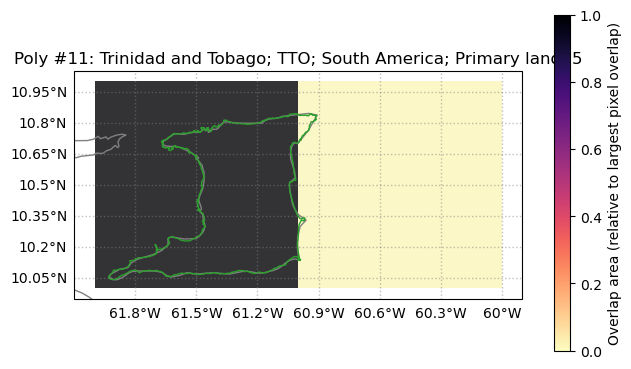

In [21]:
# using xagg's diagnostic figure to look at which grid cells 
# overlap Trinidad and Tobago (row 11 of countries dataframe)
indexrow=11
weightmap.diag_fig(indexrow,t_nino_DJF_composite.to_dataset())

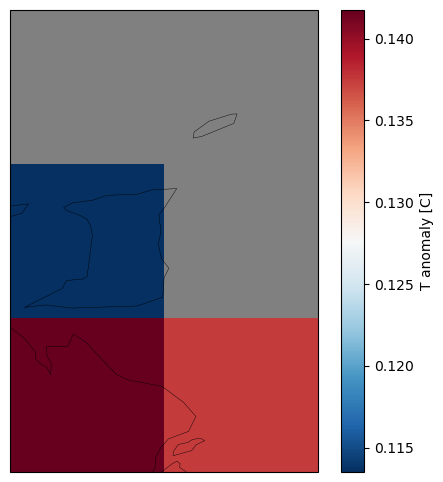

In [22]:
# making a plot to look at which grid cells of our data are considered ocean (nan)

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
# color nan grey
cmap = plt.colormaps.get_cmap("RdBu_r").copy()
cmap.set_bad('grey') 

# subset based on the above plot's lat and lon
t_nino_DJF_composite.sel(lat=slice(9.5,11.5),lon=slice(-62,-60)).plot(cmap=cmap)

As you can see above, a small part of the island is covered by an ocean grid where the data value is nan (colored grey). This is why our T_PERCENT_AREA is 98%. The nan grid cell accounts for the other 2% area of the country. It's just something to be aware of and to take into consideration when choosing a precision for presenting your results. It wouldn't make sense to present the results in this case to multiple decimal places because of this limitation of our data/analysis. 